In [1]:
import numpy as np
import pandas as pd
import math
import pickle
import matplotlib.pyplot as plt

%matplotlib inline
np.random.seed(1)

# Define neural network layers and units

In [2]:
def init_parameters(layer_dims):
    params = {}
    for l in range(1,len(layer_dims)):
        params["W"+str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2/(layer_dims[l-1]+layer_dims[l]))
        params["b"+str(l)] = np.zeros((layer_dims[l], 1))
        
    return params

In [3]:
def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    cache = (A, W, b)
    
    return Z, cache

In [4]:
def relu(Z):
    A = np.maximum(0,Z)
    cache = Z
    return A, cache

def softmax(Z, axis=None):
    cache = Z
    Z = Z - Z.max(axis=axis, keepdims=True)
    y = np.exp(Z)
    return y / np.sum(y, axis=axis, keepdims=True), cache

def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    return A, cache

In [5]:
def linear_activation_forward(A_prev, W, b, activation):
    if activation == "relu":
        Z, linear_cache  = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    elif activation == "softmax":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = softmax(Z)
    elif activation =="sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
        
    cache = (linear_cache, activation_cache)
    
    return A, cache

In [6]:
def forward_prop(X, params):
    caches = list()
    A = X
    L = len(params) // 2 # no of paramaters divided by 2 w1 and b1 for no of layers
    for l in range(1, L):
        W = params["W"+str(l)]
        b = params["b"+str(l)]
        A, cache = linear_activation_forward(A, W, b, "relu")
        caches.append(cache)
    #final layer
    W = params["W"+str(L)]
    b = params["b"+str(L)]
    AL, cache = linear_activation_forward(A, W, b, "sigmoid")
    caches.append(cache)
    
    return AL, caches

In [147]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    #logarithimic cost
    cost = -(1/m)*np.sum((Y * np.log(AL) ) + ((1 - Y)*np.log(1-AL)))
    #cost = -(1/m)*np.sum( Y * np.log(AL) )
    
    return cost

In [8]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = (1/m) * np.dot(dZ, A_prev.T)
    db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T,dZ)
    
    return dA_prev, dW, db

In [9]:
def d_cost(AL, Y):
    m = Y.shape[1]
#     dAL = -(1/1)*(Y / AL) + ((1 - Y) / (1 - AL))
#     dAL = -(1/1)*(Y / AL) + ((1 - Y) / (1 - AL))
    dAL = -(Y * (1/AL) ) + ( (1 - Y) * (1/(1-AL)) )
    return dAL

def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ

def softmax_backward(dA, cache):
    z2e = np.exp(cache)
    temp = np.zeros((z2e.shape))
    for i in range(z2e.shape[0]):
        mask = np.ones(z2e.shape, dtype=bool)
        mask[i] = 0
        temp[i] =  (z2e[i] * np.sum(z2e[mask])) / (np.sum(z2e) * 2)
    return temp * dA

def sigmoid_backward(dA, cache):
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    return dZ

In [10]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    elif activation == "softmax":
        dZ = softmax_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [1]:
def back_prop(AL, Y, caches):

    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = d_cost(AL, Y)

    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation="sigmoid")
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l+1)], current_cache, activation="relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [12]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2 
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - (learning_rate * grads["dW" + str(l+1)])
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - (learning_rate * grads["db" + str(l+1)])
    return parameters

In [329]:
def accuracy(AL, Y, threshold = 0.5):
    AL[AL <=threshold] = 0
    AL[AL >threshold] = 1
    correct = (Y == AL)
    return (np.sum(correct) /correct.shape[1]) * 100

In [406]:
def train(X, Y, layers_dims, learning_rate = 0.001, num_iterations = 1000, print_cost=True):

    costs = [] # keep track of cost
    params = init_parameters(layer_dims)

    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = forward_prop(X, params)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
    
        # Backward propagation.
        grads =  back_prop(AL, Y, caches)
 
        # Update parameters.
        params = update_parameters(params, grads, learning_rate)
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            acc = accuracy(AL, Y_train)
            print("Cost after iteration {0}: {1:.4f} - acc: {2:.2f}".format(i,cost,acc))
        if print_cost and i % 100 == 0:
            costs.append(cost)
        if cost < 0.0001:
            return params, AL
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return params, AL

In [407]:
def train_test_split(X, Y, split=80):
    dataset_size = X.shape[1]
    m_train = math.floor((dataset_size * split)/100)
    X_train = X[:,0:m_train]
    X_test = X[:,m_train-1:-1]
    Y_train = Y[:,0:m_train]
    Y_test = Y[:,m_train-1:-1]
    
    return X_train, Y_train, X_test, Y_test

In [437]:
raw_data = pd.read_csv("dataset/skin.csv")

raw_data.values[:,-1] = (raw_data.values[np.arange(0,raw_data.values.shape[0]),-1] == 1 ) + 0
shuffled_data = raw_data.sample(frac=1).reset_index(drop=True)

X = shuffled_data.values[:,0:-1].T #Transpose to make it in appropriat format
Y = np.array([shuffled_data.values[:,-1]])

###### Train, Test split

In [438]:
X_train, Y_train, X_test, Y_test = train_test_split(X, Y, 0.1)

### params saver

In [439]:
# params_1 = params # [n_x, 16, 16, n_y] , num_iterations = 10000, learning_rate=0.01

In [440]:
# params = params_1

###### Normalize and etc

In [441]:
X_train = X_train/255.
X_test = X_test/255.
m_train = X_train.shape[1]
m_test = X_test.shape[1]
n_x = X_train.shape[0]
n_y = Y_train.shape[0]

### Define network and Train it

Cost after iteration 0: 0.6707 - acc: 76.33


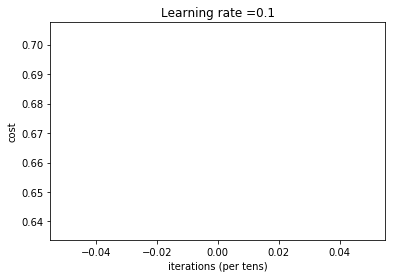

In [442]:
# # ## define the network here
layer_dims = [n_x, 16, 16, n_y]

params, AL = train(X_train, Y_train, layer_dims, print_cost=True, num_iterations = 1000, learning_rate=0.1)

In [443]:
AL, caches = forward_prop(X_train, params)

In [444]:
accuracy(AL, Y_train)

78.36734693877551

In [445]:
AL, caches = forward_prop(X_test, params)

In [446]:
accuracy(AL, Y_test)

79.24725604650118